###  STEPS:
     1. we will collect the data 
     2. Preproces the data- Train and Test
     3. Create an stacked LSTM model 
     4. Predict the test data and plot the output
     5. predict the future prediction

In [1]:
import pandas_datareader as pdr
import numpy as np

In [2]:
df = pdr.get_data_tiingo('AAPL',api_key='9ab123036407606f2ed5adc171865f6988485eca')

In [3]:
df.to_csv('APPL.csv',)

In [4]:
df.head()

close     high     low    open    volume  \
symbol date                                                                   
AAPL   2015-10-19 00:00:00+00:00  111.73  111.750  110.11  110.80  29759153   
       2015-10-20 00:00:00+00:00  113.77  114.170  110.82  111.34  48967763   
       2015-10-21 00:00:00+00:00  113.76  115.580  113.70  114.00  42326974   
       2015-10-22 00:00:00+00:00  115.50  115.500  114.10  114.33  41654089   
       2015-10-23 00:00:00+00:00  119.08  119.228  116.33  116.70  59366914   

                                   adjClose    adjHigh     adjLow    adjOpen  \
symbol date                                                                    
AAPL   2015-10-19 00:00:00+00:00  25.809095  25.813715  25.434883  25.594270   
       2015-10-20 00:00:00+00:00  26.280326  26.372724  25.598890  25.719007   
       2015-10-21 00:00:00+00:00  26.278016  26.698427  26.264156  26.333455   
       2015-10-22 00:00:00+00:00  26.679947  26.679947  26.356554  26.409683   
       2015-10-23 00:00:00+00:00  27.506910  27.541098  26.871673  26.957142   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
AAPL   2015-10-19 00:00:00+00:00  119036612      0.0          1.0  
       2015-10-20 00:00:00+00:00  195871052      0.0          1.0  
       2015-10-21 00:00:00+00:00  169307896      0.0          1.0  
       2015-10-22 00:00:00+00:00  166616356      0.0          1.0  
       2015-10-23 00:00:00+00:00  237467656      0.0          1.0

In [5]:
df1 = df.reset_index()['close']

In [6]:
df1

0       111.73
1       113.77
2       113.76
3       115.50
4       119.08
         ...  
1253    116.97
1254    124.40
1255    121.10
1256    121.19
1257    120.71
Name: close, Length: 1258, dtype: float64

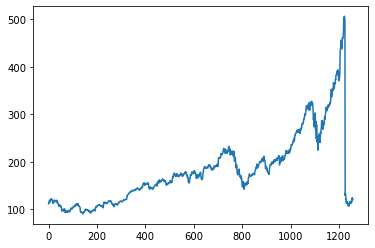

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1

array([[0.05144919],
       [0.05635598],
       [0.05633193],
       ...,
       [0.07398677],
       [0.07420325],
       [0.07304871]])

In [11]:
df1.shape

(1258, 1)

In [12]:
## spliting dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(817, 441)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)    

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [16]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [17]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [21]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 382ms/step - loss: 0.0074 - val_loss: 0.0560
Epoch 2/100
12/12 [==============================] - 2s 179ms/step - loss: 0.0015 - val_loss: 0.0231
Epoch 3/100
12/12 [==============================] - 3s 213ms/step - loss: 5.9040e-04 - val_loss: 0.0211
Epoch 4/100
12/12 [==============================] - 3s 220ms/step - loss: 4.1257e-04 - val_loss: 0.0200
Epoch 5/100
12/12 [==============================] - 2s 190ms/step - loss: 3.9966e-04 - val_loss: 0.0195
Epoch 6/100
12/12 [==============================] - 2s 201ms/step - loss: 3.3890e-04 - val_loss: 0.0193
Epoch 7/100
12/12 [==============================] - 3s 251ms/step - loss: 3.2738e-04 - val_loss: 0.0192
Epoch 8/100
12/12 [==============================] - 3s 223ms/step - loss: 3.4081e-04 - val_loss: 0.0185
Epoch 9/100
12/12 [==============================] - 2s 203ms/step - loss: 3.1352e-04 - val_loss: 0.0172
Epoch 10/100
12/12 [==============================] - 2s 199ms/

12/12 [==============================] - 2s 193ms/step - loss: 1.1523e-04 - val_loss: 0.0101
Epoch 79/100
12/12 [==============================] - 2s 193ms/step - loss: 1.0688e-04 - val_loss: 0.0095
Epoch 80/100
12/12 [==============================] - 2s 194ms/step - loss: 1.0523e-04 - val_loss: 0.0094
Epoch 81/100
12/12 [==============================] - 2s 191ms/step - loss: 1.0580e-04 - val_loss: 0.0101
Epoch 82/100
12/12 [==============================] - 2s 192ms/step - loss: 1.0170e-04 - val_loss: 0.0084
Epoch 83/100
12/12 [==============================] - 2s 190ms/step - loss: 9.7230e-05 - val_loss: 0.0082
Epoch 84/100
12/12 [==============================] - 2s 189ms/step - loss: 1.0631e-04 - val_loss: 0.0091
Epoch 85/100
12/12 [==============================] - 2s 194ms/step - loss: 1.1447e-04 - val_loss: 0.0084
Epoch 86/100
12/12 [==============================] - 2s 197ms/step - loss: 9.7391e-05 - val_loss: 0.0076
Epoch 87/100
12/12 [==============================] - 2s 20

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
train_predict

array([[103.386406],
       [103.411446],
       [103.64178 ],
       [104.16171 ],
       [104.851074],
       [105.57332 ],
       [106.21586 ],
       [106.781044],
       [107.19868 ],
       [107.42183 ],
       [107.44107 ],
       [107.51976 ],
       [107.86761 ],
       [108.39125 ],
       [109.04758 ],
       [109.82109 ],
       [110.498436],
       [111.08311 ],
       [111.3564  ],
       [111.33888 ],
       [111.16186 ],
       [111.050285],
       [111.1964  ],
       [111.57406 ],
       [111.88916 ],
       [111.856   ],
       [111.46159 ],
       [110.875175],
       [110.17122 ],
       [109.45478 ],
       [108.783356],
       [108.16836 ],
       [107.13367 ],
       [105.53454 ],
       [103.572205],
       [101.59478 ],
       [100.010506],
       [ 98.888115],
       [ 98.13578 ],
       [ 97.64178 ],
       [ 97.34371 ],
       [ 97.236496],
       [ 97.19686 ],
       [ 96.99792 ],
       [ 96.641014],
       [ 96.450516],
       [ 96.45014 ],
       [ 96.6

In [27]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

156.5668921373253

In [28]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

261.0328510477428

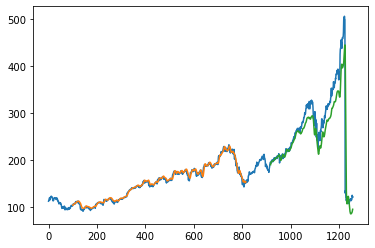

In [31]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [32]:
len(test_data)22/May

441

In [33]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
temp_input

[0.5478532772098617,
 0.5481900180396873,
 0.5474443776307878,
 0.5568490679494889,
 0.5604329524954901,
 0.5647143716175587,
 0.5579795550210462,
 0.5800601322910404,
 0.584774503908599,
 0.6101022248947685,
 0.6313890559230306,
 0.5906434155141311,
 0.5976187612748045,
 0.607696933253157,
 0.6295610342754059,
 0.6283824413710162,
 0.628719182200842,
 0.6238845460012028,
 0.6458929645219482,
 0.6643174984966926,
 0.6487552615754661,
 0.6602525556223691,
 0.6332892363199039,
 0.6528923631990378,
 0.6601563439567049,
 0.6584966927239928,
 0.6584966927239928,
 0.6819242333132893,
 0.6791340950090199,
 0.7000120264582081,
 0.7039567047504509,
 0.7055682501503309,
 0.7013108839446784,
 0.7165123271196634,
 0.7229344558027659,
 0.7113650030066145,
 0.7094888755261575,
 0.7290198436560433,
 0.7159591100420926,
 0.7185808779314491,
 0.6759831629585087,
 0.673770294648226,
 0.6948887552615755,
 0.6799037883343355,
 0.6971016235718581,
 0.7081659651232712,
 0.8050511124473845,
 0.83081178592904

In [36]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.02400108]
101
1 day input [0.54819002 0.54744438 0.55684907 0.56043295 0.56471437 0.55797956
 0.58006013 0.5847745  0.61010222 0.63138906 0.59064342 0.59761876
 0.60769693 0.62956103 0.62838244 0.62871918 0.62388455 0.64589296
 0.6643175  0.64875526 0.66025256 0.63328924 0.65289236 0.66015634
 0.65849669 0.65849669 0.68192423 0.6791341  0.70001203 0.7039567
 0.70556825 0.70131088 0.71651233 0.72293446 0.711365   0.70948888
 0.72901984 0.71595911 0.71858088 0.67598316 0.67377029 0.69488876
 0.67990379 0.69710162 0.70816597 0.80505111 0.83081179 0.83781118
 0.8416356  0.87858088 0.85173782 0.86727601 0.83502105 0.86999399
 0.88923632 0.88825015 0.8853638  0.89455201 0.89594708 0.92064943
 0.97929044 0.99360192 0.98366807 1.         0.98544799 0.9834997
 0.09308479 0.10544799 0.09876127 0.07345761 0.07365003 0.05407096
 0.06489477 0.0556825  0.05209862 0.06016837 0.06061335 0.0524113
 0.04810583 0.03968731 0.04748046 0.05164161 0.04036079 0.04300661
 0.0527721  0.05921828 0.05712568 0.

7 day output [[-0.00676156]]
8 day input [ 0.5847745   0.61010222  0.63138906  0.59064342  0.59761876  0.60769693
  0.62956103  0.62838244  0.62871918  0.62388455  0.64589296  0.6643175
  0.64875526  0.66025256  0.63328924  0.65289236  0.66015634  0.65849669
  0.65849669  0.68192423  0.6791341   0.70001203  0.7039567   0.70556825
  0.70131088  0.71651233  0.72293446  0.711365    0.70948888  0.72901984
  0.71595911  0.71858088  0.67598316  0.67377029  0.69488876  0.67990379
  0.69710162  0.70816597  0.80505111  0.83081179  0.83781118  0.8416356
  0.87858088  0.85173782  0.86727601  0.83502105  0.86999399  0.88923632
  0.88825015  0.8853638   0.89455201  0.89594708  0.92064943  0.97929044
  0.99360192  0.98366807  1.          0.98544799  0.9834997   0.09308479
  0.10544799  0.09876127  0.07345761  0.07365003  0.05407096  0.06489477
  0.0556825   0.05209862  0.06016837  0.06061335  0.0524113   0.04810583
  0.03968731  0.04748046  0.05164161  0.04036079  0.04300661  0.0527721
  0.05921828 

16 day output [[-0.00980371]]
17 day input [ 0.62388455  0.64589296  0.6643175   0.64875526  0.66025256  0.63328924
  0.65289236  0.66015634  0.65849669  0.65849669  0.68192423  0.6791341
  0.70001203  0.7039567   0.70556825  0.70131088  0.71651233  0.72293446
  0.711365    0.70948888  0.72901984  0.71595911  0.71858088  0.67598316
  0.67377029  0.69488876  0.67990379  0.69710162  0.70816597  0.80505111
  0.83081179  0.83781118  0.8416356   0.87858088  0.85173782  0.86727601
  0.83502105  0.86999399  0.88923632  0.88825015  0.8853638   0.89455201
  0.89594708  0.92064943  0.97929044  0.99360192  0.98366807  1.
  0.98544799  0.9834997   0.09308479  0.10544799  0.09876127  0.07345761
  0.07365003  0.05407096  0.06489477  0.0556825   0.05209862  0.06016837
  0.06061335  0.0524113   0.04810583  0.03968731  0.04748046  0.05164161
  0.04036079  0.04300661  0.0527721   0.05921828  0.05712568  0.06126278
  0.06361996  0.05455201  0.06292243  0.05488876  0.05950692  0.05924233
  0.06405292  0.0

25 day output [[0.00484434]]
26 day input [ 6.58496693e-01  6.81924233e-01  6.79134095e-01  7.00012026e-01
  7.03956705e-01  7.05568250e-01  7.01310884e-01  7.16512327e-01
  7.22934456e-01  7.11365003e-01  7.09488876e-01  7.29019844e-01
  7.15959110e-01  7.18580878e-01  6.75983163e-01  6.73770295e-01
  6.94888755e-01  6.79903788e-01  6.97101624e-01  7.08165965e-01
  8.05051112e-01  8.30811786e-01  8.37811185e-01  8.41635598e-01
  8.78580878e-01  8.51737823e-01  8.67276007e-01  8.35021046e-01
  8.69993987e-01  8.89236320e-01  8.88250150e-01  8.85363800e-01
  8.94552014e-01  8.95947084e-01  9.20649429e-01  9.79290439e-01
  9.93601924e-01  9.83668070e-01  1.00000000e+00  9.85447986e-01
  9.83499699e-01  9.30847865e-02  1.05447986e-01  9.87612748e-02
  7.34576067e-02  7.36500301e-02  5.40709561e-02  6.48947685e-02
  5.56825015e-02  5.20986170e-02  6.01683704e-02  6.06133494e-02
  5.24113049e-02  4.81058328e-02  3.96873121e-02  4.74804570e-02
  5.16416115e-02  4.03607937e-02  4.30066146e-02

In [37]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [38]:

import matplotlib.pyplot as plt

In [39]:
len(df1)

1258

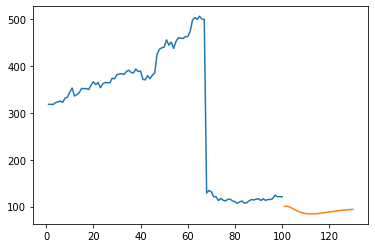

In [40]:

plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

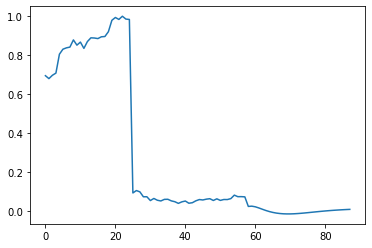

In [41]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [42]:
df3=scaler.inverse_transform(df3).tolist()

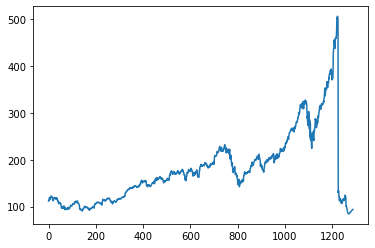

In [43]:

plt.plot(df3)